In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import os
from glob import glob
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dropout, Dense, BatchNormalization, GlobalAveragePooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import cv2 as cv
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import deque

In [3]:
# Set random seed for reproducibility
SEED = 50
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [4]:
# Constants
DATASET_DIR = '/content/drive/MyDrive/UC-101 Subset'
CLASS_NAMES = ["HammerThrow", "BaseballPitch", "Diving", "Billiards"]
FRAME_SEQUENCE_LENGTH = 20
RESIZED_HEIGHT, RESIZED_WIDTH = 128, 128
NUM_FEATURES = 1024

In [5]:
# Data Augmentation
def augment_frames(frames):
    """
    Applies random augmentations to frames to improve generalization.
    """
    augmented_frames = []
    for frame in frames:
        if random.random() > 0.5:  # Flip horizontally
            frame = cv.flip(frame, 1)
        if random.random() > 0.7:  # Add random brightness
            factor = 0.5 + random.uniform(0, 1.5)
            frame = np.clip(frame * factor, 0, 1)
        augmented_frames.append(frame)
    return np.array(augmented_frames)

In [6]:
# Frame extraction function
def extract_video_frames(video_path, augment=False):
    """
    Extracts frames from a video, resizes, normalizes, and optionally augments them.
    """
    frames = []
    video_capture = cv.VideoCapture(video_path)
    total_frames = int(video_capture.get(cv.CAP_PROP_FRAME_COUNT))
    frame_interval = max(total_frames // FRAME_SEQUENCE_LENGTH, 1)

    for frame_idx in range(total_frames):
        video_capture.set(cv.CAP_PROP_POS_FRAMES, frame_idx * frame_interval)
        success, frame = video_capture.read()
        if not success:
            break
        resized_frame = cv.resize(frame, (RESIZED_WIDTH, RESIZED_HEIGHT))
        normalized_frame = resized_frame / 255.0
        frames.append(normalized_frame)
        if len(frames) == FRAME_SEQUENCE_LENGTH:
            break

    video_capture.release()
    frames = np.asarray(frames)
    return augment_frames(frames) if augment else frames

In [7]:
# Dataset creation function
def prepare_video_dataset(augment=False):
    """
    Creates a dataset from video files, extracting frames and assigning labels.
    """
    data_labels = []
    data_features = []

    for class_idx, class_name in enumerate(CLASS_NAMES):
        video_paths = glob(os.path.join(DATASET_DIR, class_name) + "/*")
        print(f"Processing {class_name}: {len(video_paths)} videos")

        for video_path in video_paths:
            frames = extract_video_frames(video_path, augment=augment)
            if len(frames) == FRAME_SEQUENCE_LENGTH:
                data_features.append(frames)
                data_labels.append(class_idx)
            else:
                print(f"Skipping {video_path} (not enough frames)")

    data_features = np.array(data_features)
    data_labels = np.array(data_labels)
    return data_features, data_labels

In [8]:
# Load and preprocess dataset with augmentation
video_features, video_labels = prepare_video_dataset(augment=True)
video_labels = to_categorical(video_labels, num_classes=len(CLASS_NAMES))
X_train, X_test, y_train, y_test = train_test_split(video_features, video_labels, test_size=0.33, random_state=42)

Processing HammerThrow: 150 videos
Processing BaseballPitch: 150 videos
Processing Diving: 150 videos
Processing Billiards: 150 videos


In [9]:
# Save features and labels as separate .npy files
np.save('features.npy', video_features)
np.save('labels.npy', video_labels)

In [10]:
# Define ViViT components
class TubuletEmbedding(Layer):
    def __init__(self, embedding_dim, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.conv3d = tf.keras.layers.Conv3D(filters=embedding_dim, kernel_size=patch_size, strides=patch_size, padding="VALID",
                                             kernel_regularizer=tf.keras.regularizers.l2(0.01))
        self.flatten = tf.keras.layers.Reshape(target_shape=(-1, embedding_dim))

    def call(self, inputs):
        projected_patches = self.conv3d(inputs)
        return self.flatten(projected_patches)

In [11]:
class PositionalEncoding(Layer):
    def __init__(self, embedding_dim, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim = embedding_dim

    def build(self, input_shape):
        _, num_tokens, _ = input_shape
        self.position_embedding = tf.keras.layers.Embedding(input_dim=num_tokens, output_dim=self.embedding_dim)
        self.positions = tf.range(start=0, limit=num_tokens, delta=1)

    def call(self, inputs):
        positional_encodings = self.position_embedding(self.positions)
        return inputs + positional_encodings

In [12]:
# ViViT model definition
def build_vivit_model(input_shape=(20, 128, 128, 3), transformer_layers=8, num_heads=8, embed_dim=128, norm_epsilon=1e-6, num_classes=4):
    tubulet_embedder = TubuletEmbedding(embed_dim, patch_size=(8, 8, 8))
    pos_encoder = PositionalEncoding(embed_dim)

    inputs = tf.keras.layers.Input(shape=input_shape)
    patches = tubulet_embedder(inputs)
    encoded_patches = pos_encoder(patches)

    for _ in range(transformer_layers):
        norm1 = tf.keras.layers.LayerNormalization(epsilon=norm_epsilon)(encoded_patches)
        attention = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim // num_heads, dropout=0.1)(norm1, norm1)
        add1 = tf.keras.layers.Add()([attention, encoded_patches])

        norm2 = tf.keras.layers.LayerNormalization(epsilon=norm_epsilon)(add1)
        feed_forward = tf.keras.Sequential([
            tf.keras.layers.Dense(units=embed_dim * 4, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
            Dropout(0.2),
            tf.keras.layers.Dense(units=embed_dim, activation='relu'),
        ])(norm2)
        encoded_patches = tf.keras.layers.Add()([feed_forward, add1])

    representation = tf.keras.layers.LayerNormalization(epsilon=norm_epsilon)(encoded_patches)
    pooled_representation = GlobalAveragePooling1D()(representation)
    outputs = tf.keras.layers.Dense(units=num_classes, activation="softmax")(pooled_representation)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [13]:
# Compile and train model with learning rate scheduler
vivit_model = build_vivit_model()
vivit_model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
checkpoint = ModelCheckpoint('vivit_optimized.h5.keras', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

In [15]:
vivit_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 20, 128, 128, 3)]    0         []                            
                                                                                                  
 tubulet_embedding (Tubulet  (None, 512, 128)             196736    ['input_1[0][0]']             
 Embedding)                                                                                       
                                                                                                  
 positional_encoding (Posit  (None, 512, 128)             65536     ['tubulet_embedding[0][0]']   
 ionalEncoding)                                                                                   
                                                                                              

In [16]:
training_history = vivit_model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=8, callbacks=[checkpoint, early_stopping, lr_scheduler])

Epoch 1/100
41/41 [==============================] - 112s 2s/step - loss: 17.5272 - accuracy: 0.3738 - val_loss: 17.1057 - val_accuracy: 0.3580 - lr: 1.0000e-04
Epoch 2/100
41/41 [==============================] - 99s 2s/step - loss: 16.5601 - accuracy: 0.4455 - val_loss: 15.9600 - val_accuracy: 0.6049 - lr: 1.0000e-04
Epoch 3/100
41/41 [==============================] - 99s 2s/step - loss: 15.5652 - accuracy: 0.5794 - val_loss: 15.2104 - val_accuracy: 0.6049 - lr: 1.0000e-04
Epoch 4/100
41/41 [==============================] - 99s 2s/step - loss: 14.6525 - accuracy: 0.6885 - val_loss: 14.2306 - val_accuracy: 0.6173 - lr: 1.0000e-04
Epoch 5/100
41/41 [==============================] - 99s 2s/step - loss: 13.9582 - accuracy: 0.6729 - val_loss: 13.7140 - val_accuracy: 0.5432 - lr: 1.0000e-04
Epoch 6/100
41/41 [==============================] - 99s 2s/step - loss: 13.1663 - accuracy: 0.7259 - val_loss: 12.8909 - val_accuracy: 0.6667 - lr: 1.0000e-04
Epoch 7/100
41/41 [====================

In [17]:
# Evaluate the model
loss, test_accuracy = vivit_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")

7/7 [==============================] - 23s 3s/step - loss: 1.6777 - accuracy: 0.9192
Test Accuracy: 0.9191918969154358


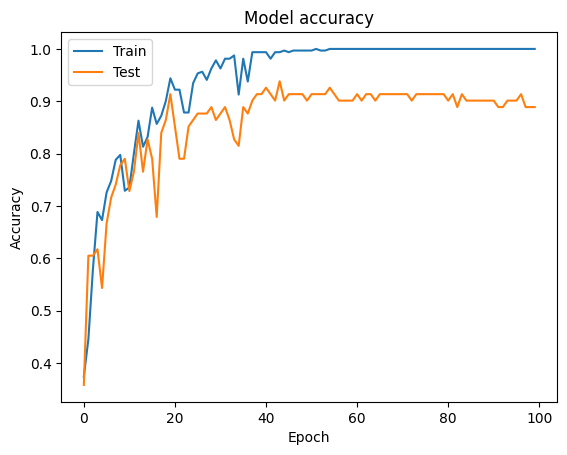

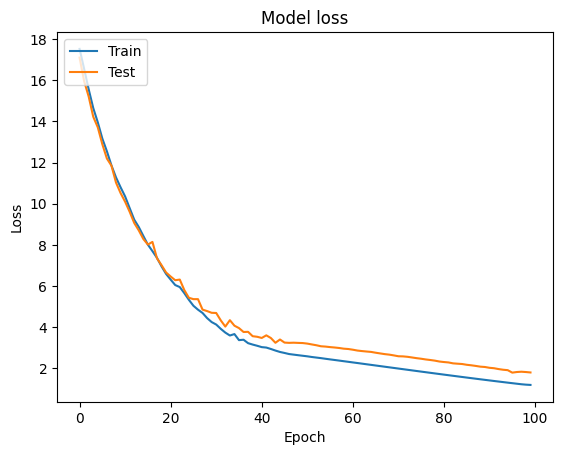

In [18]:
import matplotlib.pyplot as plt

# Plotting training & validation accuracy values
plt.plot(training_history.history['accuracy'])
plt.plot(training_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plotting training & validation loss values
plt.plot(training_history.history['loss'])
plt.plot(training_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

7/7 [==============================] - 22s 3s/step
Accuracy: 0.9192
Precision: 0.9228
Recall: 0.9192
F1 Score: 0.9189


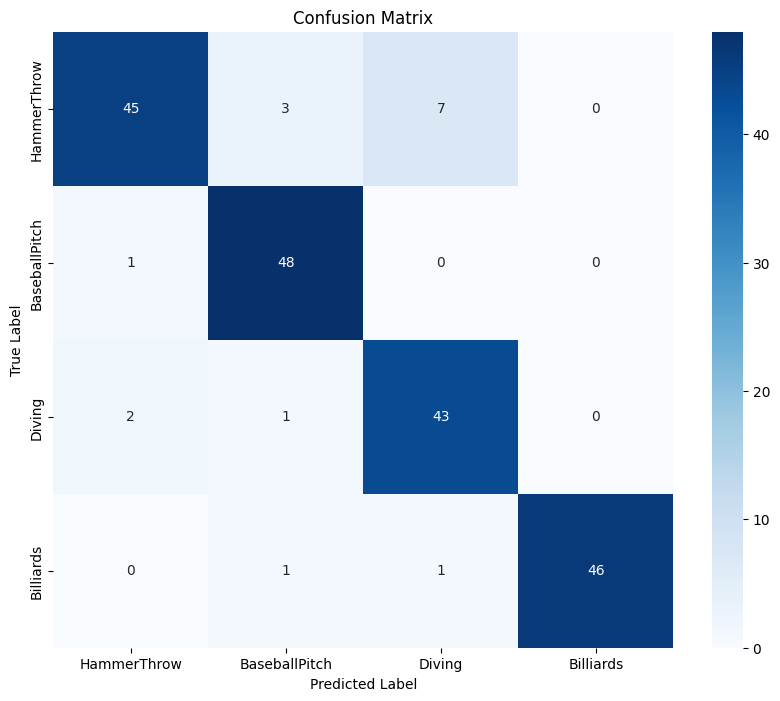

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

# Predict on test set
y_pred_prob = vivit_model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [21]:
    import cv2 as cv
    import numpy as np
    from collections import deque

    # Define the classes and sequence length as per your model.
    class_names = ["HammerThrow", "BaseballPitch", "Diving", "Billiards"]
    seq_len = 20
    resized_height, resized_width = 128, 128

    def extract_frames_for_test(video_path, seq_len):
        extracted_frames = []
        video_reader = cv.VideoCapture(video_path)
        total_frames = int(video_reader.get(cv.CAP_PROP_FRAME_COUNT))
        skip_frames = max(total_frames // seq_len, 1)

        for frame_counter in range(0, total_frames, skip_frames):
            video_reader.set(cv.CAP_PROP_POS_FRAMES, frame_counter)
            success, frame = video_reader.read()
            if not success:
                break
            resized_frame = cv.resize(frame, (resized_width, resized_height))
            normalized_frame = resized_frame / 255.0
            extracted_frames.append(normalized_frame)
            if len(extracted_frames) == seq_len:
                break

        video_reader.release()
        return np.array(extracted_frames)

    def test_video_classification(video_path, model, output_video):
        video_reader = cv.VideoCapture(video_path)
        video_writer = cv.VideoWriter(
            output_video,
            cv.VideoWriter_fourcc(*"mp4v"),
            video_reader.get(cv.CAP_PROP_FPS),
            (int(video_reader.get(cv.CAP_PROP_FRAME_WIDTH)), int(video_reader.get(cv.CAP_PROP_FRAME_HEIGHT)))
        )

        frame_queue = deque(maxlen=seq_len)

        while video_reader.isOpened():
            success, frame = video_reader.read()
            if not success:
                break
            resized_frame = cv.resize(frame, (resized_width, resized_height))
            normalized_frame = resized_frame / 255.0
            frame_queue.append(normalized_frame)

            if len(frame_queue) == seq_len:
                input_frames = np.expand_dims(np.array(frame_queue), axis=0)
                predictions = model.predict(input_frames)[0]

                for idx, prob in enumerate(predictions):
                    label = f"{class_names[idx]}: {prob:.2f}"
                    cv.putText(frame, label, (10, 30 + idx * 20), cv.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)

            video_writer.write(frame)

        video_reader.release()
        video_writer.release()
        print(f"Output video saved as {output_video}")

In [23]:
input_video = "/content/drive/MyDrive/test_video/test3.mp4"
output_video = "/content/drive/MyDrive/demo/demo3_tubulet.mp4"
# Call the function
test_video_classification(input_video, vivit_model, output_video)

1/1 [==============================] - 0s 99ms/step
Output video saved as /content/drive/MyDrive/demo/demo3_tubulet.mp4


In [24]:
input_video = "/content/drive/MyDrive/test_video/test4.mp4"
output_video = "/content/drive/MyDrive/demo/demo4_tubulet.mp4"
# Call the function
test_video_classification(input_video, vivit_model, output_video)

1/1 [==============================] - 0s 97ms/step
Output video saved as /content/drive/MyDrive/demo/demo4_tubulet.mp4
